In [1]:
from IPython.display import Code, Image

# Simulation using Graphical States

Daniel Knüttel 2020

## Performance Benefits of the Graphical Simulator

While writing the thesis several benchmarks have been made comparing graphical simulation with dense state vector simulation. The benchmarks clearly show the performance benefit of using the graphical simulator:

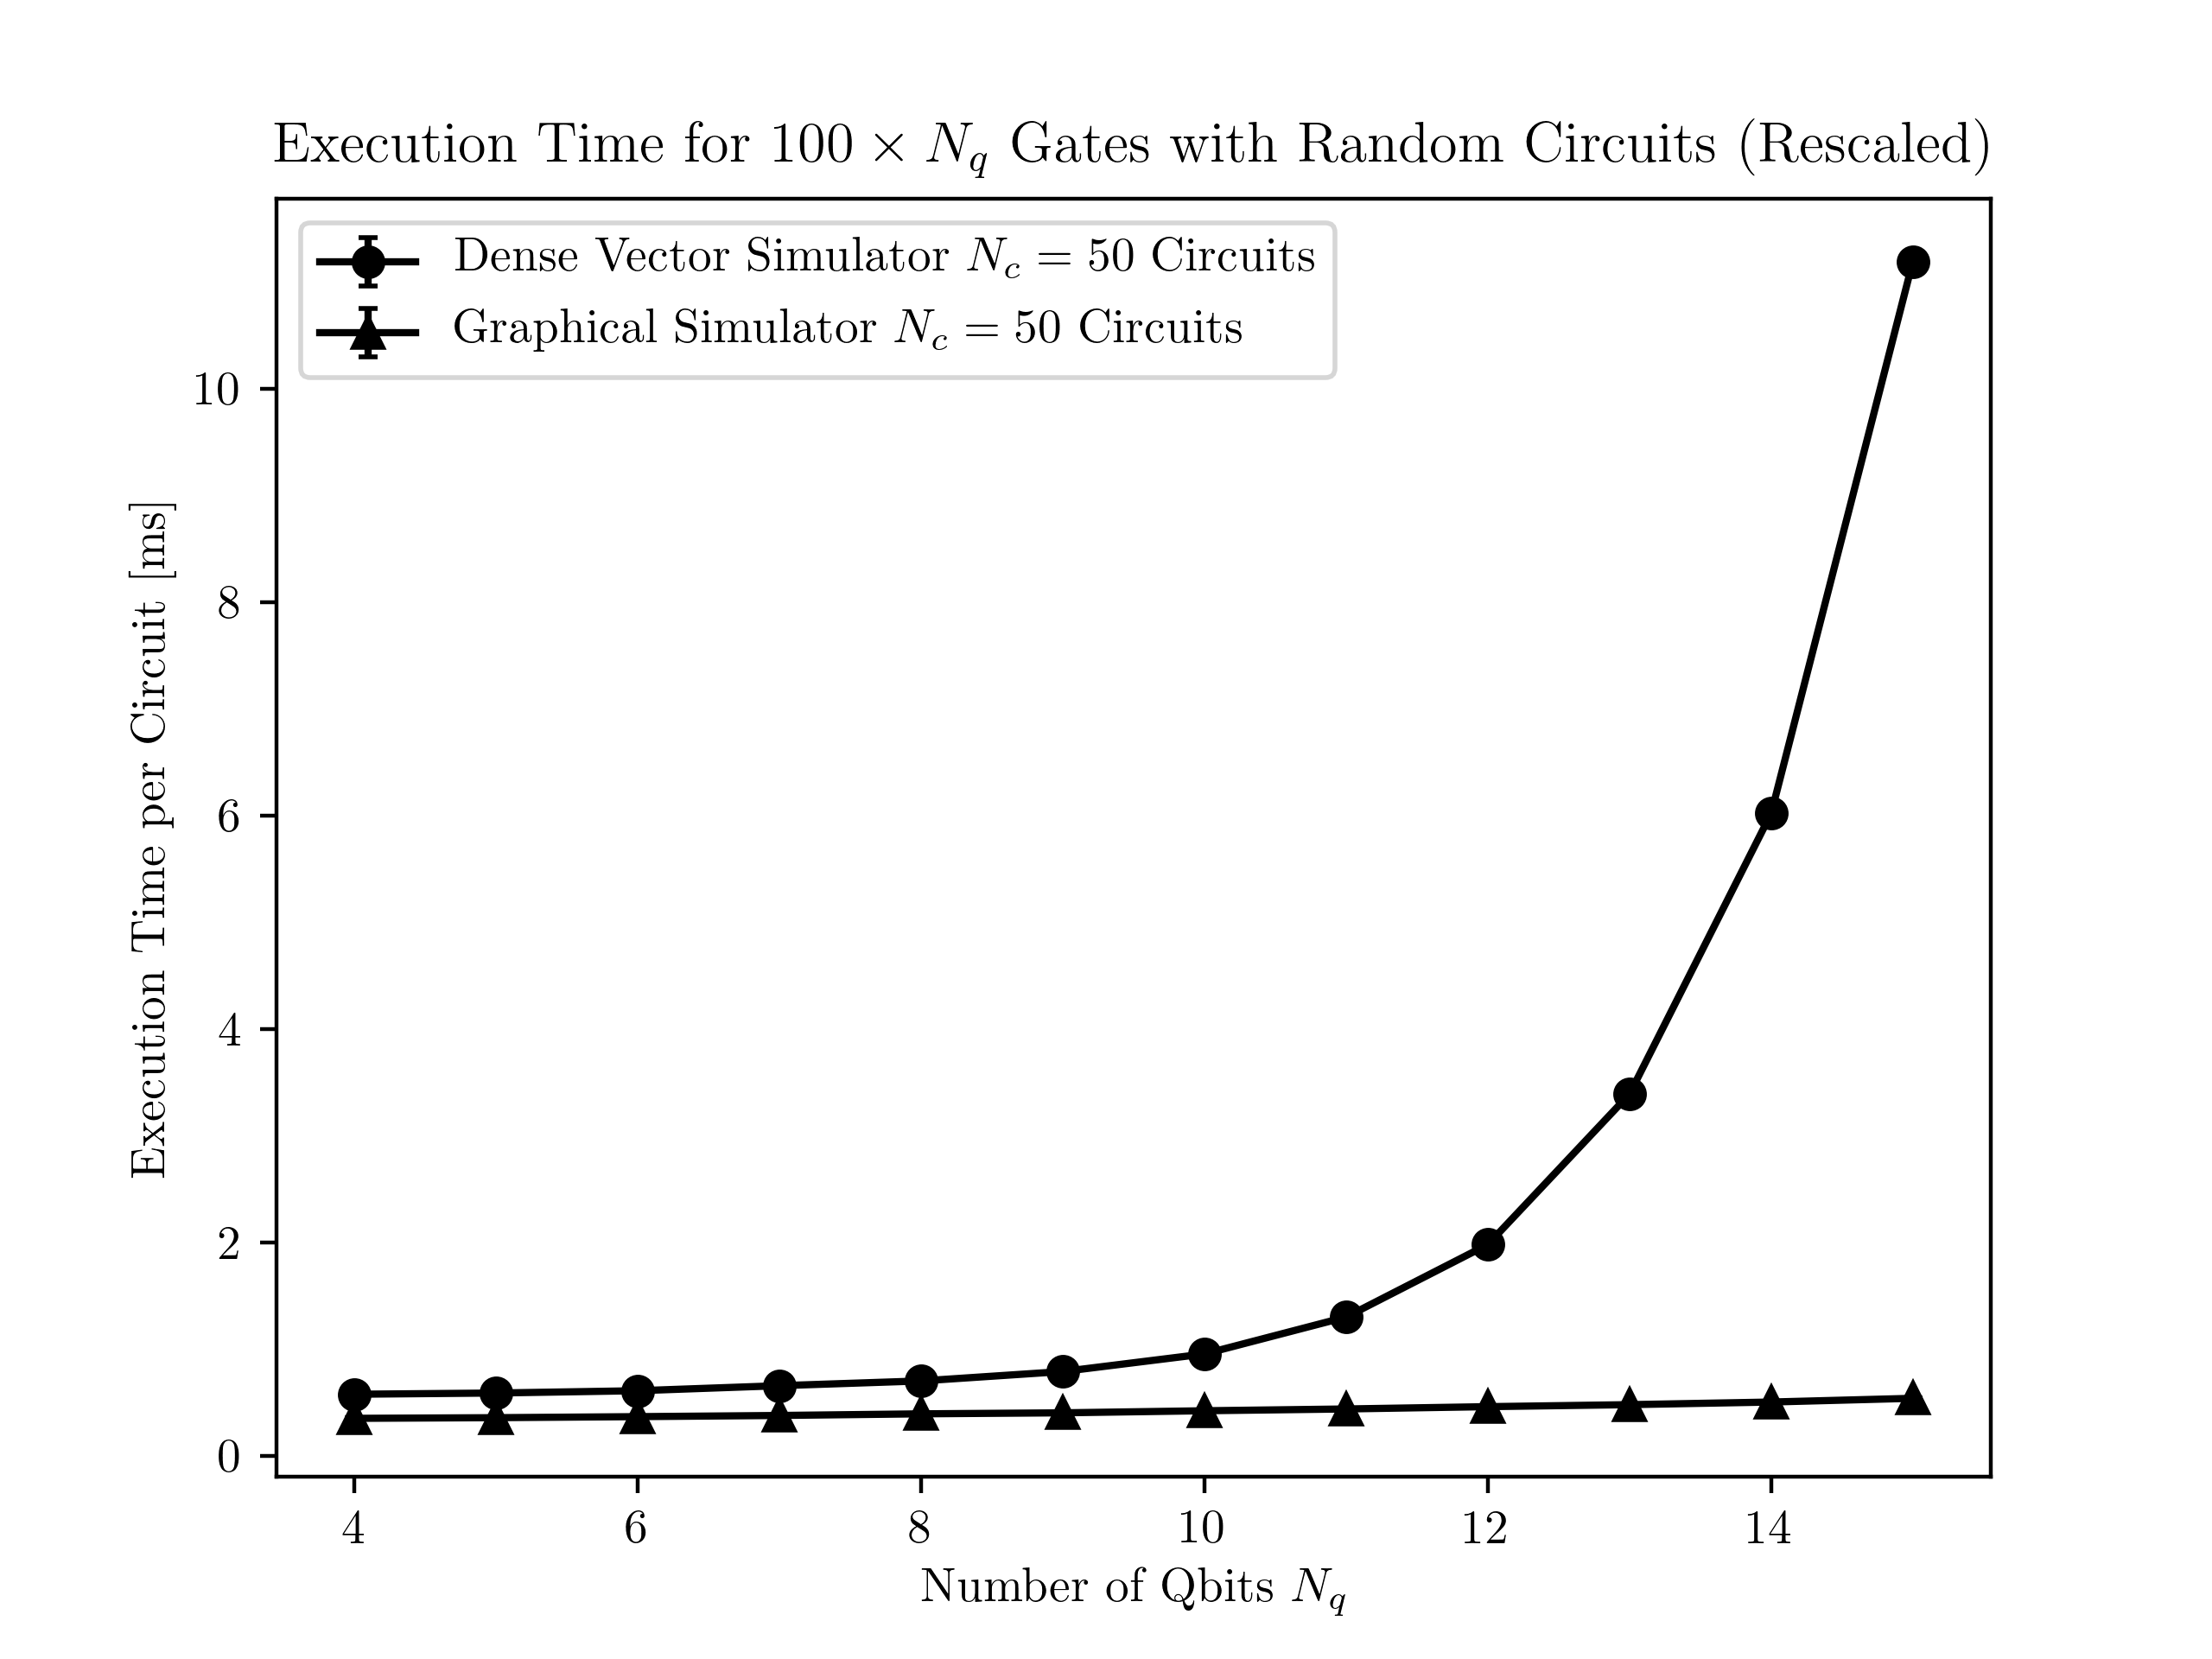

In [2]:
Image("images/scaling_qbits_linear.png")

Note that the errorbars (computed using bootstrap) is suppressed by the exponential growth of the dense simulator. The number of gates is $N_g = 100\times N_q$ the number of qbits and the execution time is then divided by $N_q$. This is necessary because the performance of the graphical state depends on entanglement.

A plot on logarithmic scale shows the indeed exponential behaviour of the dense simulator and a sub-exponential behaviour of the graphical simulator:

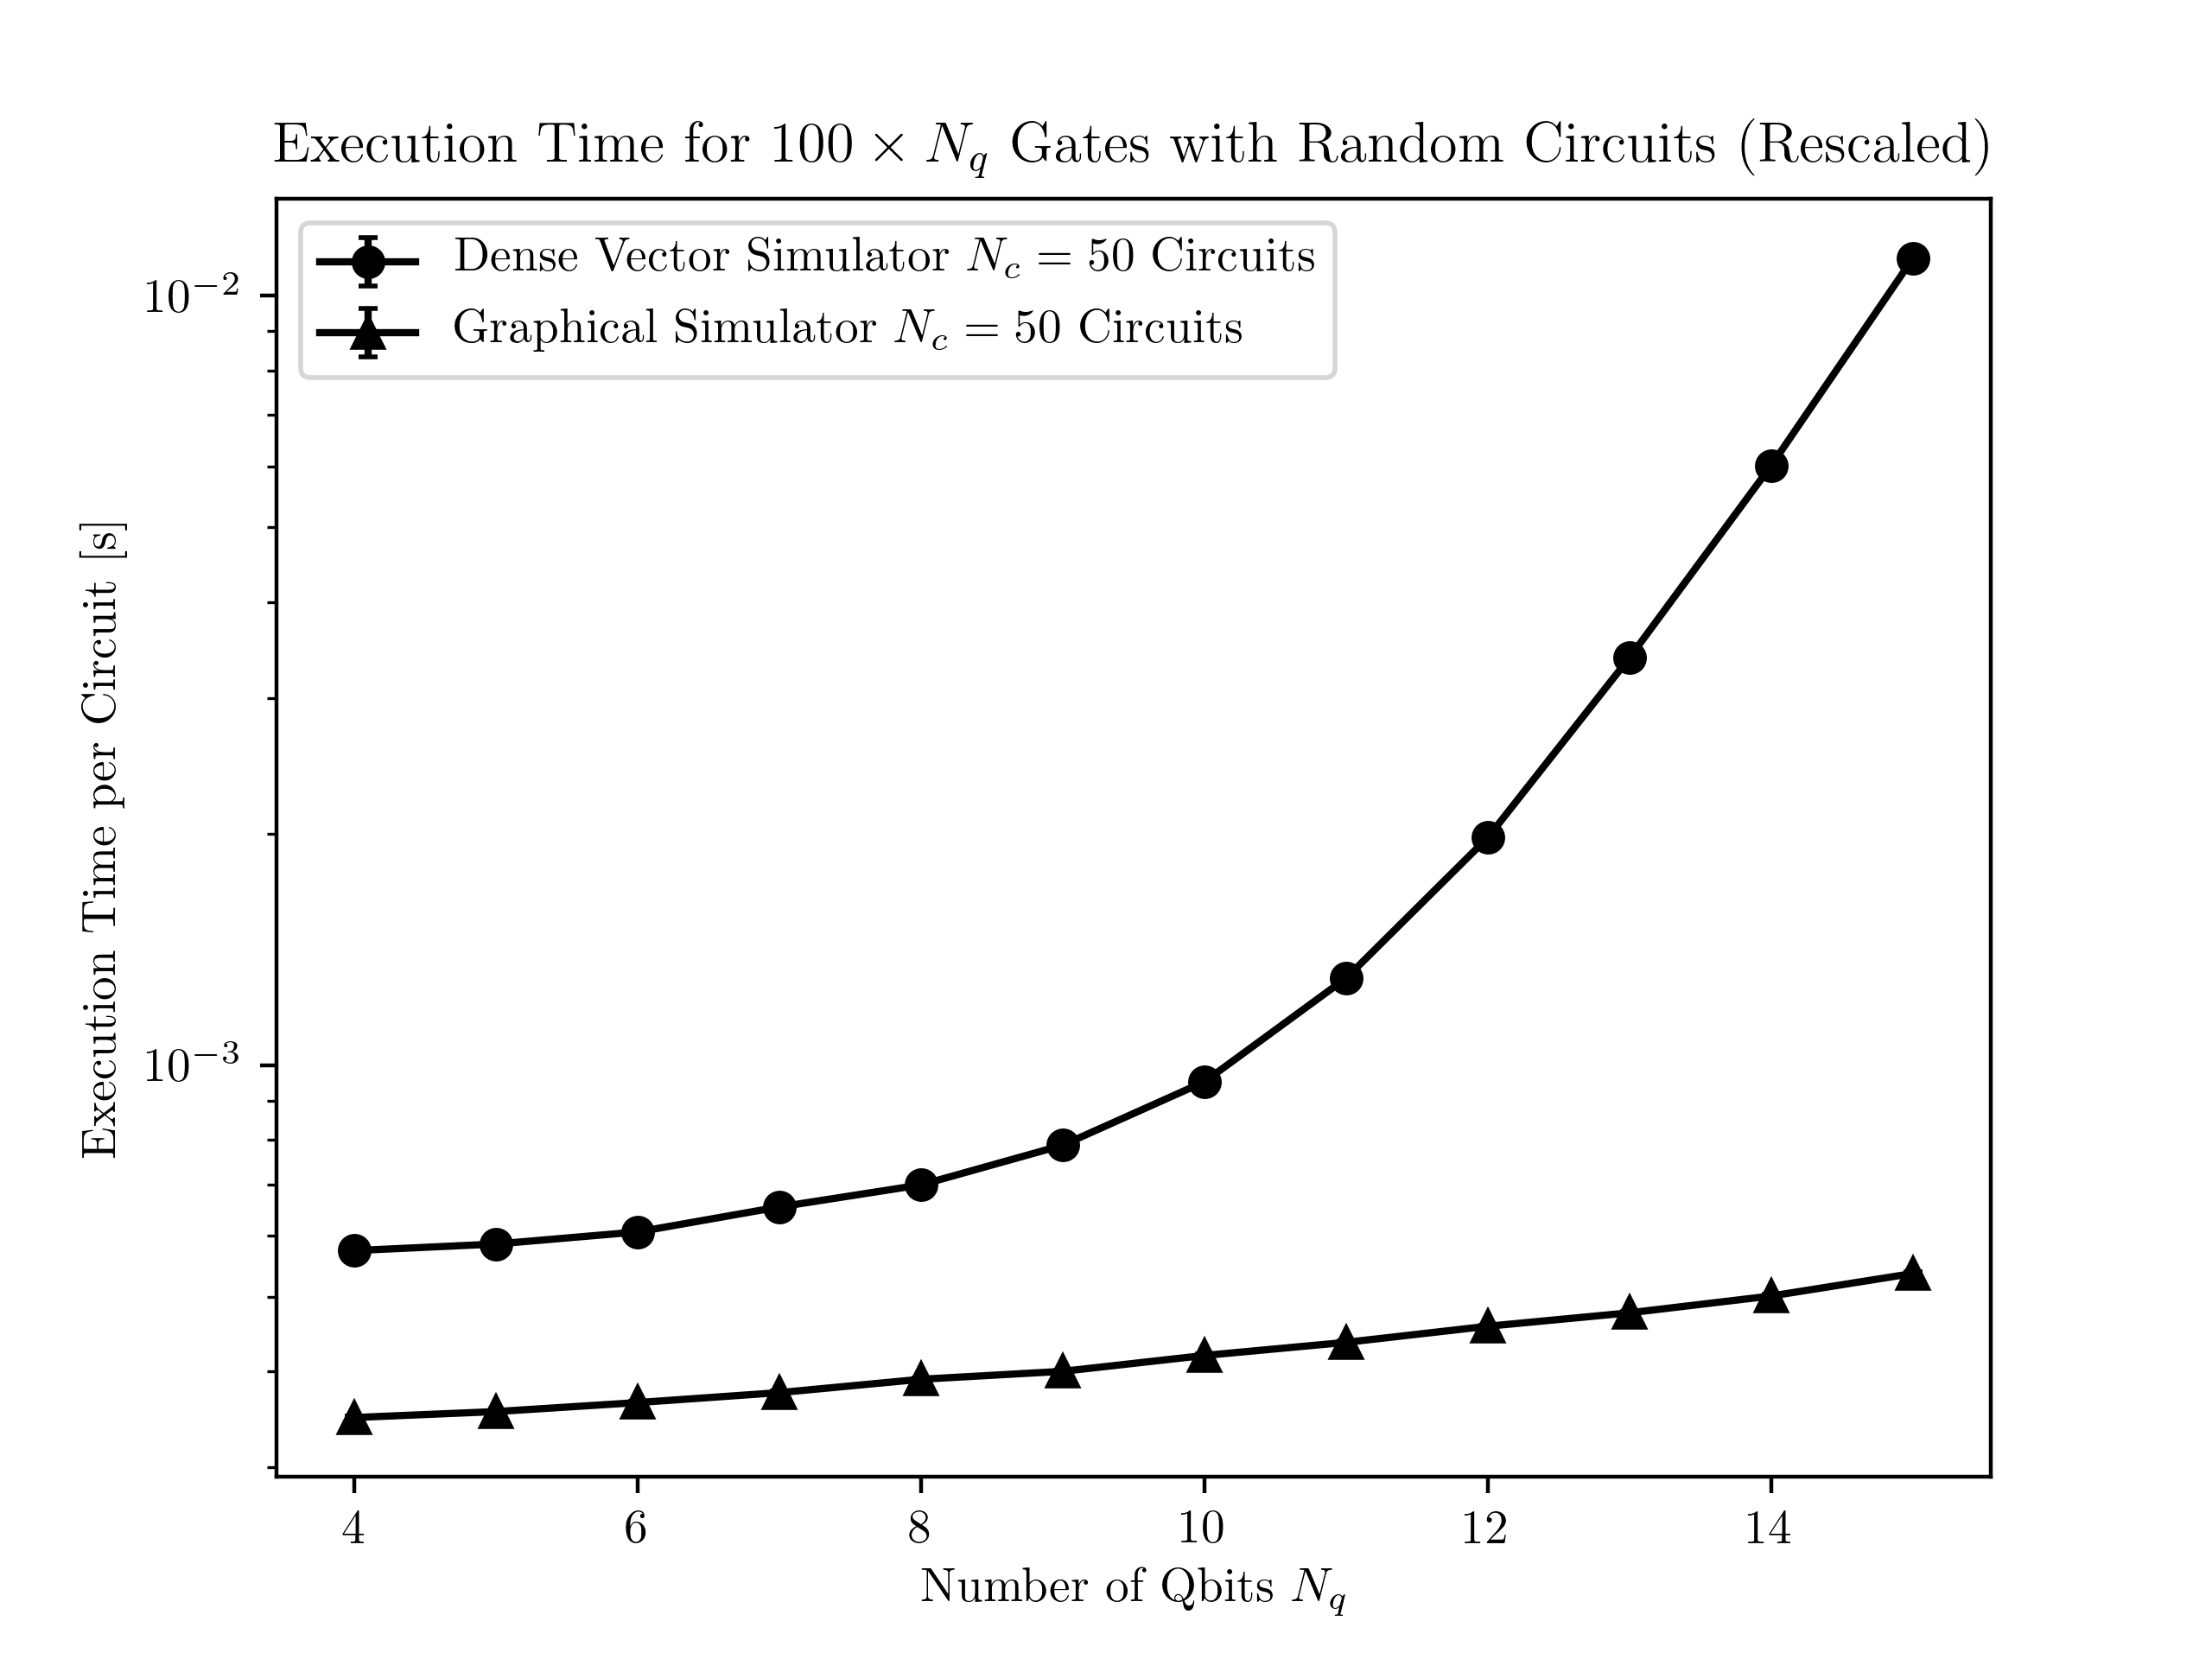

In [3]:
Image("images/scaling_qbits_log.png")

The time complexity of the graphical simulator is bounded from above by $\mathcal{O}(N_q^2)$  with a realistic behaviour of $\mathcal{O}(N_q\log(N_q))$ (*Anders, Briegel 2005*).

## Computations Using the Graphical Simulator

We will now demonstrate the example of the Bell (or EPR) state on 2, and 400 qbits. In the first example the graphical state is converted to a dense vector state for demonstration purposes; in the second example it would be impossible to compute the dense vector state on a classical computer.

In [4]:
!pip3 show pyqcs

Name: pyqcs
Version: 2.2.4
Summary: A quantum computing simulator.
Home-page: https://github.com/daknuett/pyqcs
Author: Daniel Knüttel
Author-email: daniel.knuettel@daknuett.eu
License: GNU General Public License v3 (GPLv3)
Location: /home/daniel/.envs/QC/lib/python3.7/site-packages
Requires: numpy
Required-by: 


In [5]:
import pyqcs

from pyqcs import H, S, Z, X, CX, CZ, circuitpng, sample, list_to_circuit
from pyqcs.graph.state import GraphState as State

In [6]:
state = State.new_zero_state(2) # instantiate a new graphical |0> state

We apply a circuit to the state to obtain the Bell state:

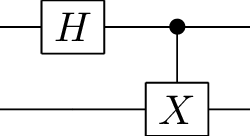

In [7]:
circuit = (H(0) | CX(1, 0)) # gates are applied left-to-right
circuitpng(circuit) # render the circuit as a PNG in the notebook

In [8]:
bell_state = circuit * state # multiply circuit to state to apply it
bell_state.to_naive_state() # convert the graphical state to a dense vector state

(0.7071067800000002+0j)*|0b0> + (0.7071067800000002+0j)*|0b11>

The "graph" associated with this state is:

In [9]:
bell_state._g_state.to_lists() # representation of the graphical state as python lists

([2, 0], [[1], [0]])

The first list are integers associated with the vertex operators (ranging from $0$ to $24$), the second list contains the adjacency lists. The vertex operators in this example are $0 \equiv H$, $2 \equiv I$.

In [10]:
sample(bell_state # state to sample from
       , [0, 1] # qbits to measure
       , 100 # number of samples
      )

Counter({0: 54, 3: 46})

We see that indeed the first two qbits are entangled.

We now move to $400$ qbits, which would require around $2^{400}\cdot 16$ bytes (around $10^{106}$ petabytes) to store as a dense state vector: 

In [11]:
nqbits = 400
state = State.new_zero_state(nqbits)

The circuit to obtain the EPR state is longer than in the first example and will be generated programmatically. It has this form:

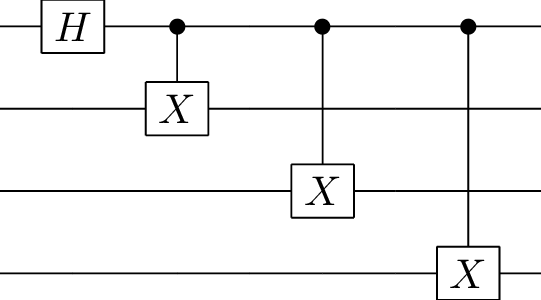

In [12]:
circuitpng(H(0) | CX(1, 0) | CX(2, 0) | CX(3, 0))

In [13]:
circuit = H(0) | list_to_circuit([CX(i, 0) for i in range(1, nqbits)]) # generate the circuit

In [14]:
epr_state = circuit * state

In [15]:
sample(epr_state
       , list(range(nqbits)) # all qbits
       , 100)

Counter({0: 50,
         2582249878086908589655919172003011874329705792829223512830659356540647622016841194629645353280137831435903171972747493375: 50})

This result is quite unreadable because $400$ bit numbers are pretty long, even more in binary:

In [16]:
bin(2582249878086908589655919172003011874329705792829223512830659356540647622016841194629645353280137831435903171972747493375)

'0b1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'

But you can see that the results are correct: Both entanglement and wave function collaps are handled.

## Future Work

We are working on a circuit opimizer using graphical states. When starting from the $|0\rangle$ state one can already use the graphical simulator to compress circuits:

In [17]:
from pyqcs.util.to_circuit import graph_state_to_circuit

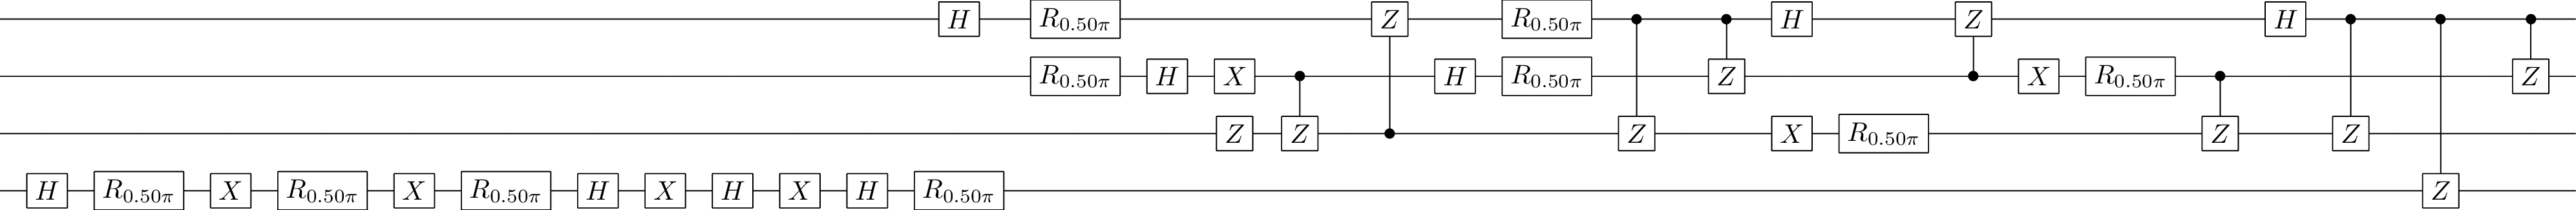

In [18]:
circuit = (H(3) | S(3) | X(3) | S(3) | X(3) | S(3) | H(3) | X(3) | H(3) | X(3)
            | H(3) | S(3) | H(0) | S(0) | S(1) | H(1) | X(1) | Z(2)
            | CZ(2, 1) | CZ(0, 2) | H(1) | S(1) | S(0) | CZ(2, 0) | CZ(1, 0)
            | H(0) | X(2) | S(2) | CZ(0, 1) | X(1) | S(1) | CZ(2, 1) 
            | H(0) | CZ(2, 0) | CZ(3, 0) | CZ(1, 0))
circuitpng(circuit)

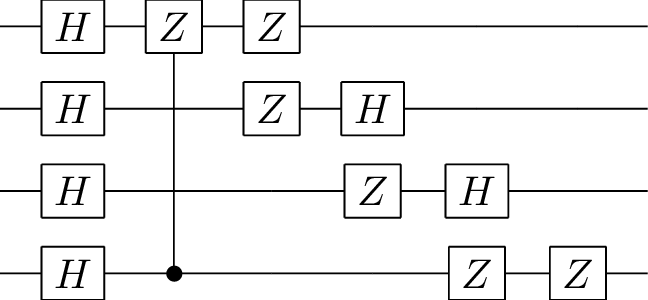

In [19]:
state = circuit * State.new_zero_state(4)
new_circuit = graph_state_to_circuit(state) # convert graphical state to circuit
circuitpng(new_circuit) # applying this circuit to |0> will give the same state (up to a global phase)

This circuit obviously needs more optimization (for instance $HZH = X$, and $ZZ = I$), but it is a step towards a new optimizer for Clifford circuits.

In [20]:
state1 = circuit * pyqcs.State.new_zero_state(4) # pyqcs.State is a dense vector
state2 = new_circuit * pyqcs.State.new_zero_state(4)
abs(state1 @ state2) # compute the overlap of states using matrix multiplication

1.0000000000000002

The states obtained by the two circuits have (up to a global phase) overlap $1$.

Another approach currently being investigated is to use superpositions of graphical states to simulate non-Clifford circuits.